In [41]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import *
from utilities.plotting import plot_exposure_contour, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter, plot_variable_histogram, plot_income_groups
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

In [42]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

# Read in often used values from config
with open('exposure_function_params_{0}.pkl'.format(config['availability_function']), 'rb') as f:
    params = pickle.load(f)

if config['availability_function'] == 'power_law':
    avail_func = power_avail
elif config['availability_function'] == 'exponential':
    avail_func = exp_avail
elif config['availability_function'] == 'combined_exponential':
    avail_func = None
else:
    raise ValueError('Availability function not recognized')

ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

# Read in income groups from World Bank data
income_groups = pd.read_excel(config['world_bank_income_groups_file'])
income_groups = income_groups[['Code', 'Income group']]

In [43]:
def exposure_new(cdd, gdp):
    if avail_func is not None:
        return exposure_function((cdd, gdp), avail_func, params['cdd_scale'], params['alpha'], params['k'])
    else:
        return exposure_combined_exponential((cdd, gdp), params['cdd_scale'], params['alpha'], params['k'])

In [44]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Cooling deficit Index analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    gdp_data_years = []
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year]
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
            gdp_data_year = gdp_data_year.rename(columns={'Year': 'Year_past'})
        gdp_data_years.append(gdp_data_year)
    gdp_data = pd.merge(gdp_data_years[0], gdp_data_years[1], on='ISO3')

    ac_data_historical = pd.merge(cdd_data, gdp_data, on=['ISO3', 'Year'], how='left')
    ac_data_historical = ac_data_historical.rename(columns={'Year': 'Year_ref'})
        
    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
            ac_data_historical['GDP_past'], ac_data_historical['Year_ref'] - ac_data_historical['Year_past'])

    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical, year=config['analysis_years']['future_year'])
    
    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')

    # Formatting
    # Drop rows where year past is NaN
    ac_data = ac_data.dropna(subset=['Year_past'])
    ac_data.reset_index(drop=True, inplace=True)
    ac_data['Year_past'] = ac_data['Year_past'].astype(int)
    # Replace infinities with empty values
    ac_data = ac_data.replace(np.inf, np.nan)

    # Add column for historical heat exposure
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'])*ac_data['CDD']
    ac_data['ac_adoption'] = 1. - exposure_new(ac_data['CDD'], ac_data['GDP'])

    # Sort by income quantile and label each country with income group
    ac_data = pd.merge(ac_data, income_groups, left_on='ISO3', right_on='Code', how='left').rename(columns={'Income group': 'income_group'})
    # Drop Code
    ac_data = ac_data.drop(columns=['Code'])
    # Income group names drop 'income' and make lower
    ac_data['income_group'] = ac_data['income_group'].str.replace(' income', '').str.lower()
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data = calculate_gdp_const(ac_data, config, params)

    # Write full dataframe to csv
    if not os.path.exists(outfile_path):
        ac_data.to_csv(outfile_path)
    
    print(ac_data)



INFO:root:Cooling deficit Index analysis results not found, recalculating
INFO:root:No data for AFG in 1990
INFO:root:Found data for AFG in 2002
INFO:root:No data for AND in 1990
INFO:root:No data for AND in any year
INFO:root:No data for ASM in 1990
INFO:root:No data for ASM in any year
INFO:root:No data for BIH in 1990
INFO:root:Found data for BIH in 1994
INFO:root:No data for CHI in 1990
INFO:root:No data for CHI in any year
INFO:root:No data for CUB in 1990
INFO:root:No data for CUB in any year
INFO:root:No data for CUW in 1990
INFO:root:Found data for CUW in 2000
INFO:root:No data for CYM in 1990
INFO:root:Found data for CYM in 2006
INFO:root:No data for DJI in 1990
INFO:root:Found data for DJI in 2013
INFO:root:No data for ERI in 1990
INFO:root:No data for ERI in any year
INFO:root:No data for EST in 1990
INFO:root:Found data for EST in 1995
INFO:root:No data for FRO in 1990
INFO:root:No data for FRO in any year
INFO:root:No data for GIB in 1990
INFO:root:No data for GIB in any y

    ISO3         Country         CDD  Year_ref  Year_past     GDP_past  \
0    AFG     Afghanistan   876.75506      2019       2002  1280.463171   
1    ALB         Albania   630.35247      2019       1990  4827.027705   
2    DZA         Algeria  1231.21753      2019       1990  8828.874473   
3    ASM  American Samoa  3369.90188      2019       1990          NaN   
4    AGO          Angola  2169.94281      2019       1990  5793.084512   
..   ...             ...         ...       ...        ...          ...   
203  VNM        Viet Nam  3034.63204      2019       1990  2099.394649   
204  WSM   Western Samoa  3105.88948      2019       1990  3655.951872   
205  YEM           Yemen  2152.03753      2019       1990          NaN   
206  ZMB          Zambia  1596.08778      2019       1990  2290.039226   
207  ZWE        Zimbabwe  1442.73567      2019       1990  2704.757299   

              GDP  gdp_historical_growth  CDD_ssp1_rcp26_2100  \
0     2079.921861               0.028947      

In [45]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data.drop(columns=['ISO3', 'Country']).dropna()
print(ac_data_income_group)
ac_data_income_group = ac_data_income_group.groupby('income_group').median()

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

# Calculate GDP needed to keep exposure times CDD constant
for scenario in config['future_scenarios']:
    ac_data_income_group = calculate_gdp_const(ac_data_income_group, config, params)


# Add column to ac_data for GDP needed to get everyone to the exposure times cdd of the high income group
ac_data = calculate_gdp_const(ac_data, config, params, exp_cdd=ac_data_income_group.loc['high', 'exposure_times_cdd'])

INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([71, 82], dtype='int64'), possibly 0 CDD
INFO:r

            CDD  Year_ref  Year_past      GDP_past           GDP  \
0     876.75506      2019       2002   1280.463171   2079.921861   
1     630.35247      2019       1990   4827.027705  13653.182207   
2    1231.21753      2019       1990   8828.874473  11627.279918   
6     850.95843      2019       1990  14136.525401  22071.748100   
7     367.09430      2019       1990   5153.298211  14317.552869   
..          ...       ...        ...           ...           ...   
201  1080.56806      2019       1990   3638.876840   7403.742780   
203  3034.63204      2019       1990   2099.394649  10252.004622   
204  3105.88948      2019       1990   3655.951872   6346.256341   
206  1596.08778      2019       1990   2290.039226   3372.358980   
207  1442.73567      2019       1990   2704.757299   2203.396810   

     gdp_historical_growth  CDD_ssp1_rcp26_2100  CDD_ssp2_rcp45_2100  \
0                 0.028947               1078.0               1346.0   
1                 0.036504             

In [46]:
# Get the color on the GDP map for each income group in RGB
cmap = plt.cm.get_cmap(config['plotting']['gdp_cmap'])
norm = mcolors.LogNorm(vmin=config['plotting']['gdp_min'], vmax=config['plotting']['gdp_max'])
ac_data_income_group['gdp_color'] = ac_data_income_group['GDP'].apply(lambda x: mcolors.rgb2hex(cmap(norm(x))))
print(ac_data_income_group['gdp_color'])

income_group
high            #84d44b
low             #472c7a
lower middle    #2d708e
upper middle    #21a585
Name: gdp_color, dtype: object


In [47]:
# Add CDD difference between 2100 and ref year
for scenario in config['future_scenarios']:
    ac_data['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data['CDD']

In [73]:
print("Numerical values quoted in the publication:\n")

# Calculate p-value for correlation coefficient
print("\nRelated to Fig.1")
ac_data_no_nans = ac_data.dropna(subset=['CDD', 'GDP'])
corr = pearsonr(ac_data_no_nans['CDD'], ac_data_no_nans['GDP'].apply(np.log))[0]
p_value = pearsonr(ac_data_no_nans['CDD'], ac_data_no_nans['GDP'].apply(np.log))[1]
# Print countries with CDD diff nan
ac_data_no_nans = ac_data_no_nans.dropna(subset=['CDD_ssp2_rcp45_2100_diff', 'GDP'])
corr_diff = pearsonr(ac_data_no_nans['CDD_ssp2_rcp45_2100_diff'], ac_data_no_nans['GDP'].apply(np.log))[0]
p_value_diff = pearsonr(ac_data_no_nans['CDD_ssp2_rcp45_2100_diff'], ac_data_no_nans['GDP'].apply(np.log))[1]
print("Correlation of CDD and log of GDP: {}, with p-value: {}".format(corr, p_value))
print("Correlation of CDD increase and GDP: {}, with p-value: {}".format(corr_diff, p_value_diff))

# Minimum and maximum CDD for low income group, round to integer
print("\nRelated to Fig.2")
print("Minimum CDD for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD'].min()))
print("Maximum CDD for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD'].max()))
print("Maximum CDD increase for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD_ssp2_rcp45_2100_diff'].max()))
# Countries of low income group with less than 500 CDD diff
print("Countries of low income group with less than 500 CDD increase: ", ac_data[(ac_data['income_group'] == 'low') & (ac_data['CDD_ssp2_rcp45_2100_diff'] < 500)]['Country'].values)

# Print GDP factor getting CDI to high income value over avoiding CDI increase
print("\nRelated to Fig.4")
growth_ratio = ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd']/ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45']
print('GDP growth ratio of reaching high income CDI over avoiding increase in CDI for low income group: {}'.format(growth_ratio.mean()))
print('Low income group GDP growth rates: historical {}; to avoid increase in CDI {}; to reach high income CDI {}'
      .format(ac_data[ac_data['income_group'] == 'low']['gdp_historical_growth'].mean(), ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45'].mean(), 
              ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd'].mean()))

print("\nRelated to Methods")
# Countries with CDD smaller than the projection
print("Countries with CDD smaller than the projection in 2100:")
print(ac_data[ac_data['CDD_ssp2_rcp45_2100'] < ac_data['CDD']]['Country'].values)


Numerical values quoted in the publication:


Related to Fig.1
Correlation of CDD and log of GDP: -0.36879848399627996, with p-value: 1.4127694712228868e-07
Correlation of CDD increase and GDP: -0.5265898412354602, with p-value: 3.735353449969018e-13

Related to Fig.2
Minimum CDD for low income group: 532.02947
Maximum CDD for low income group: 3993.88824
Maximum CDD increase for low income group: 1200.99743
Countries of low income group with less than 500 CDD increase:  ['Afghanistan' "Democratic People's Republic of Korea" 'Madagascar'
 'Yemen']

Related to Fig.4
GDP growth ratio of reaching high income CDI over avoiding increase in CDI for low income group: 1.8725964812068314
Low income group GDP growth rates: historical 0.01193022671135623; to avoid increase in CDI 0.02776688083854846; to reach high income CDI 0.0494825841419604

Related to Methods
Countries with CDD smaller than the projection in 2100:
['Comoros' 'French Polynesia']


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https:

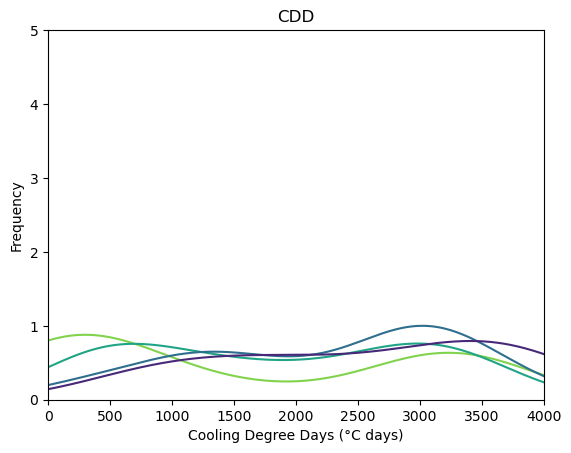

<Figure size 640x480 with 0 Axes>

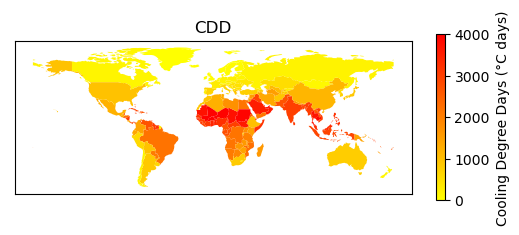

<Figure size 640x480 with 0 Axes>

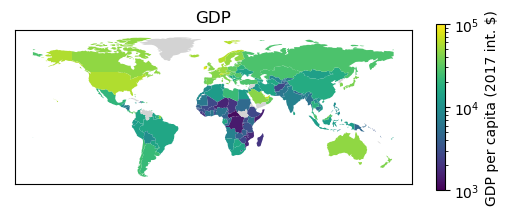

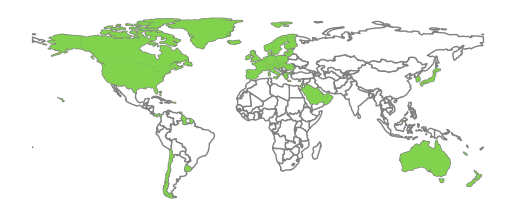

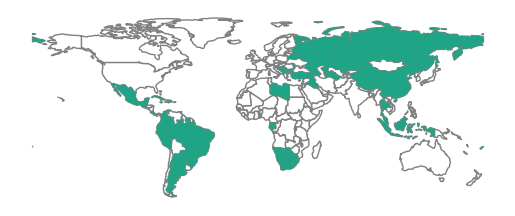

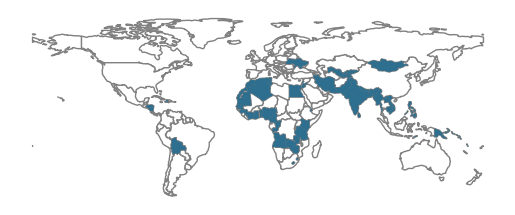

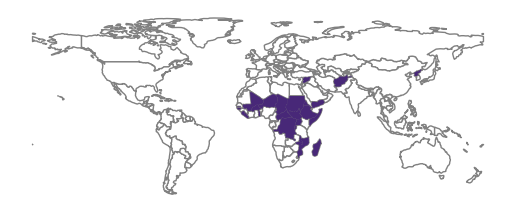

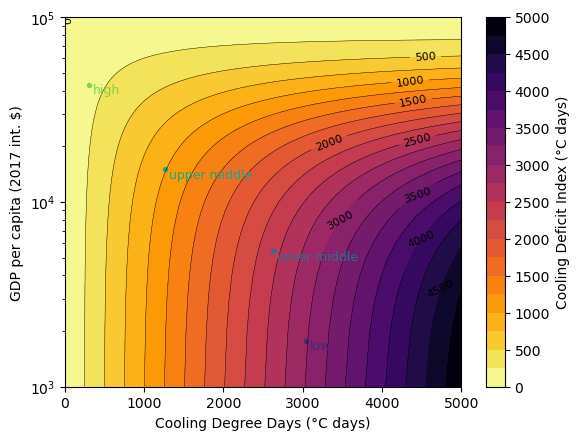

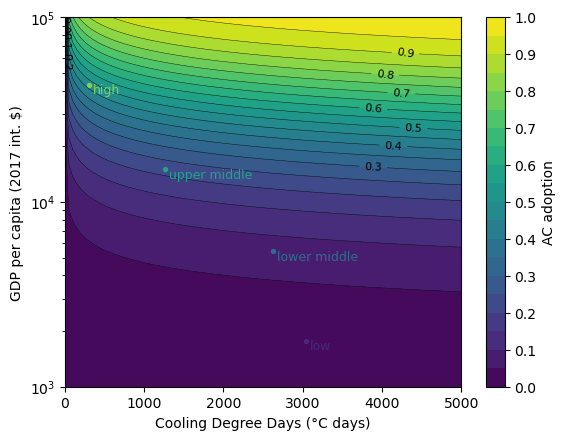

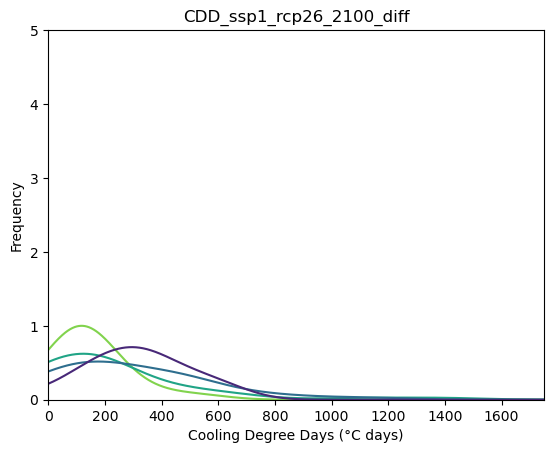

<Figure size 640x480 with 0 Axes>

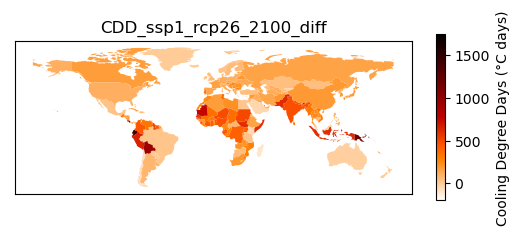

<Figure size 640x480 with 0 Axes>

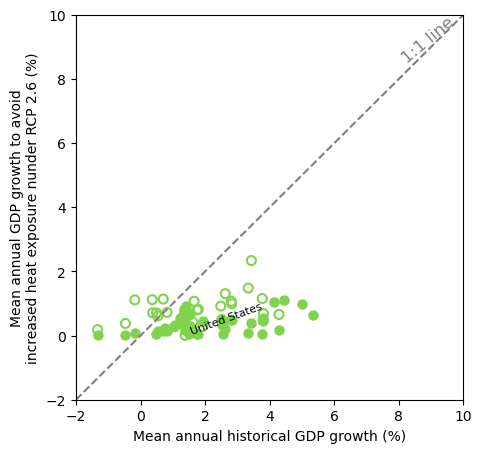

<Figure size 640x480 with 0 Axes>

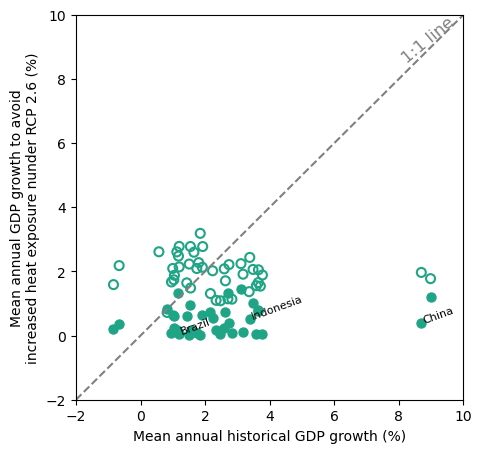

<Figure size 640x480 with 0 Axes>

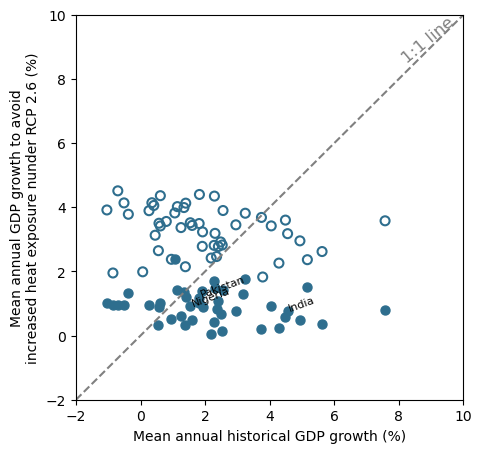

<Figure size 640x480 with 0 Axes>

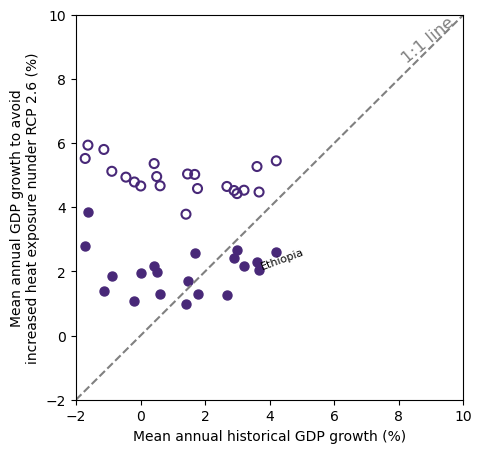

<Figure size 640x480 with 0 Axes>

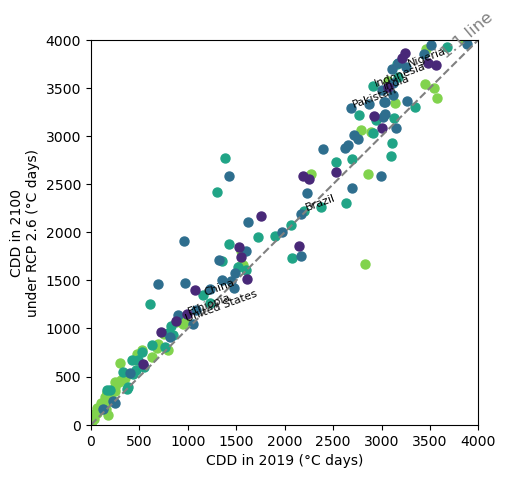

<Figure size 640x480 with 0 Axes>

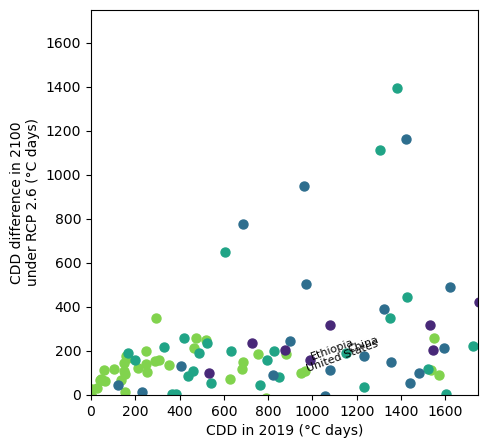

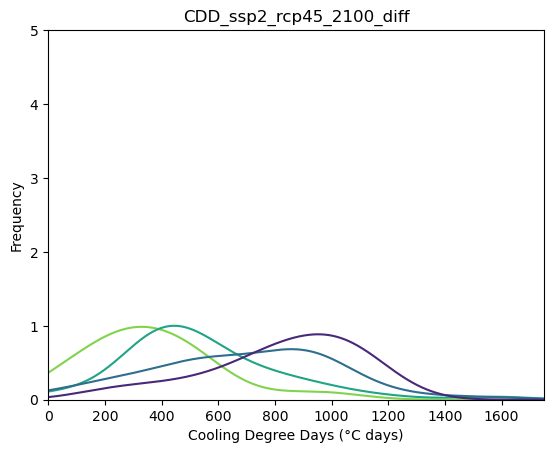

<Figure size 640x480 with 0 Axes>

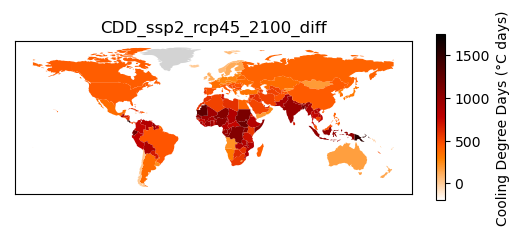

<Figure size 640x480 with 0 Axes>

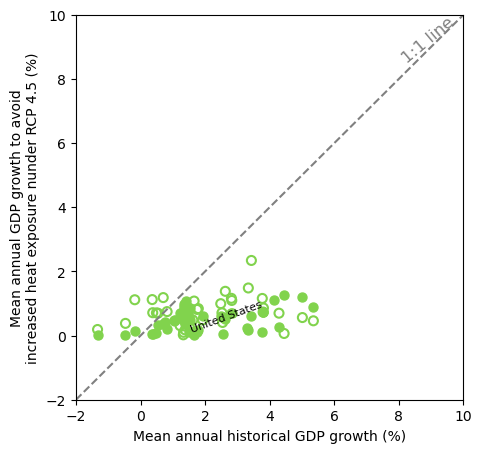

<Figure size 640x480 with 0 Axes>

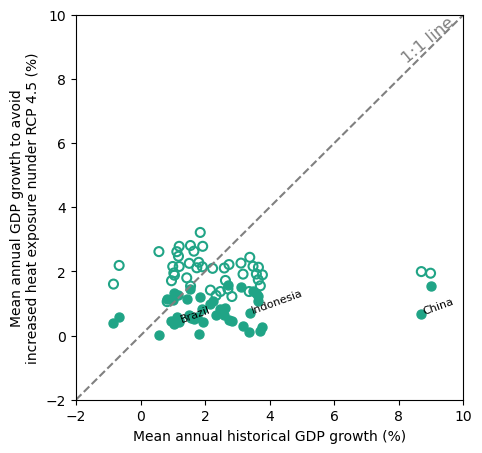

<Figure size 640x480 with 0 Axes>

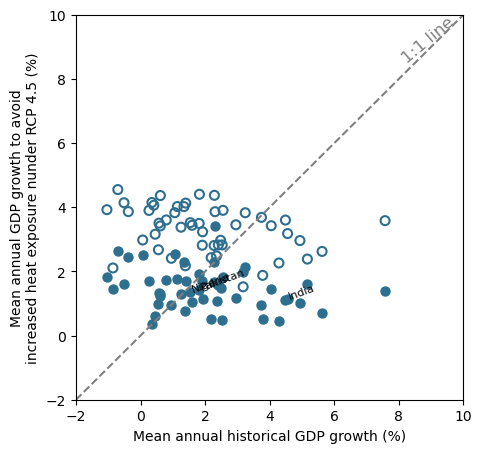

<Figure size 640x480 with 0 Axes>

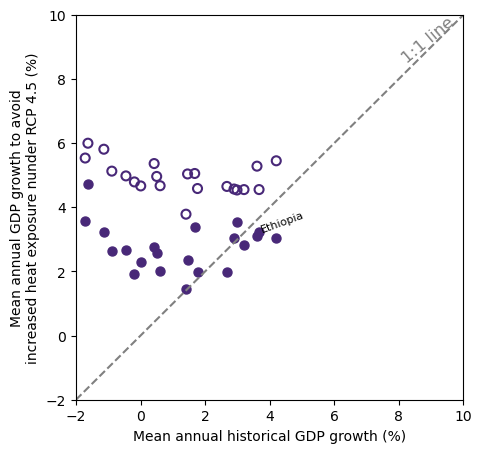

<Figure size 640x480 with 0 Axes>

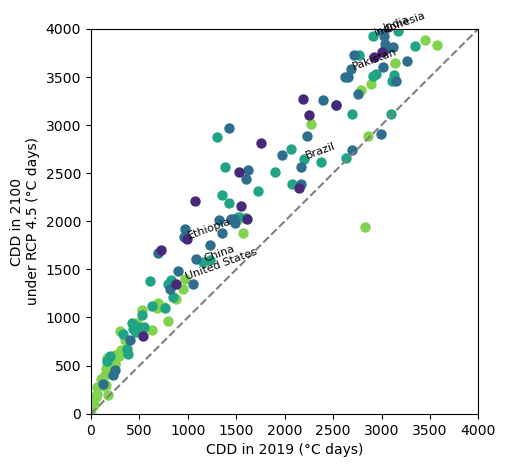

<Figure size 640x480 with 0 Axes>

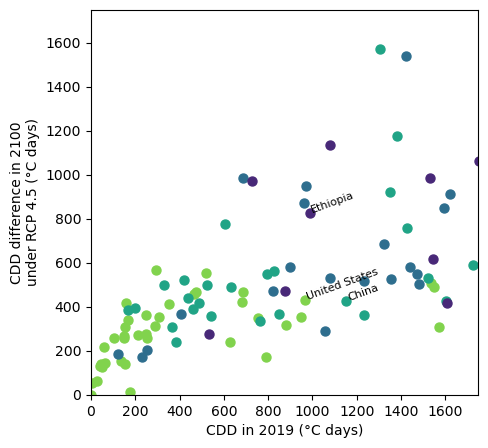

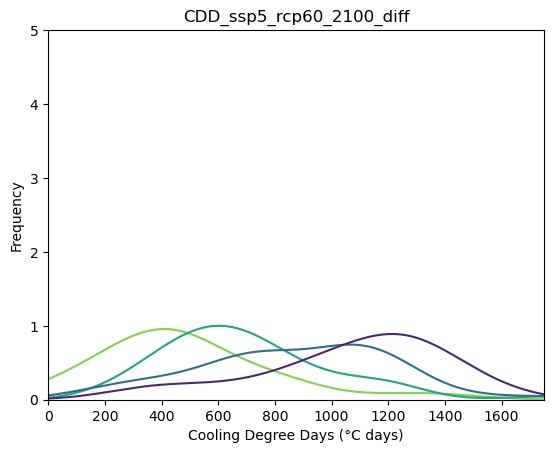

<Figure size 640x480 with 0 Axes>

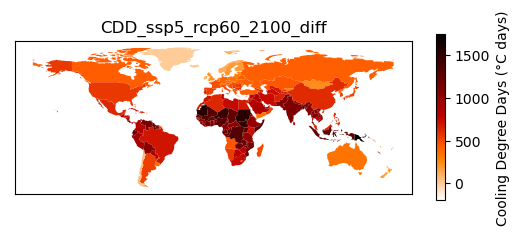

<Figure size 640x480 with 0 Axes>

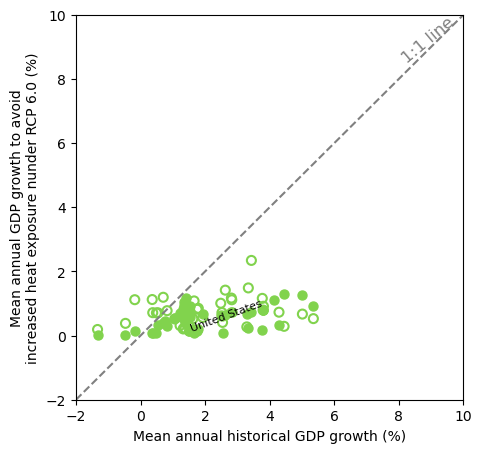

<Figure size 640x480 with 0 Axes>

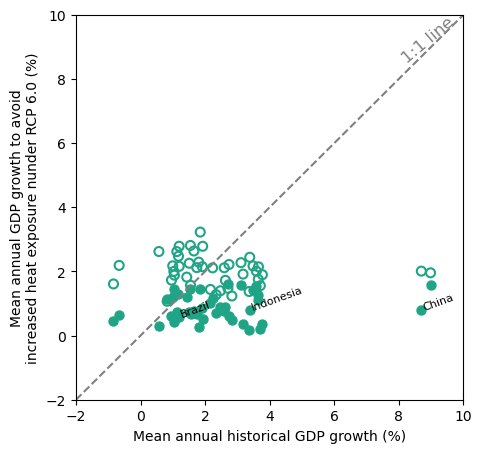

<Figure size 640x480 with 0 Axes>

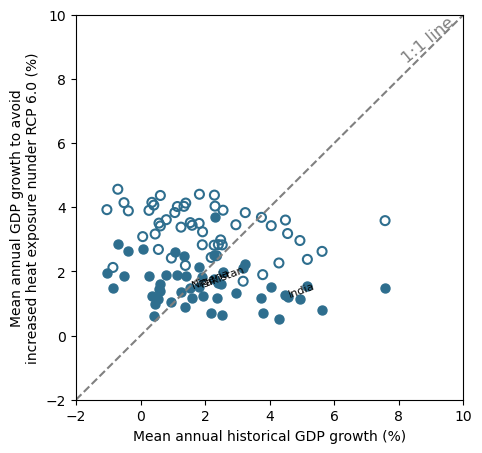

<Figure size 640x480 with 0 Axes>

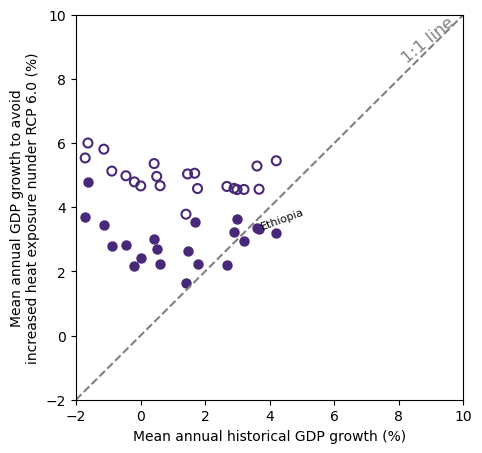

<Figure size 640x480 with 0 Axes>

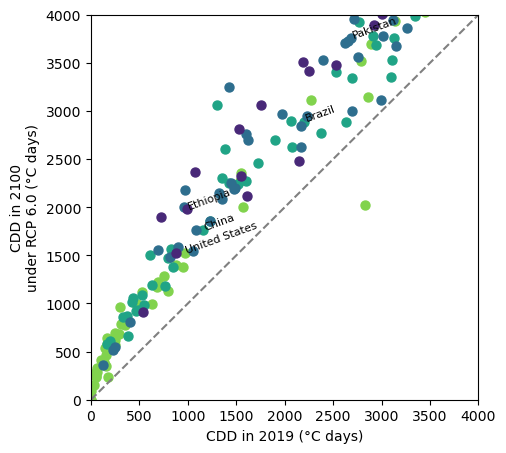

<Figure size 640x480 with 0 Axes>

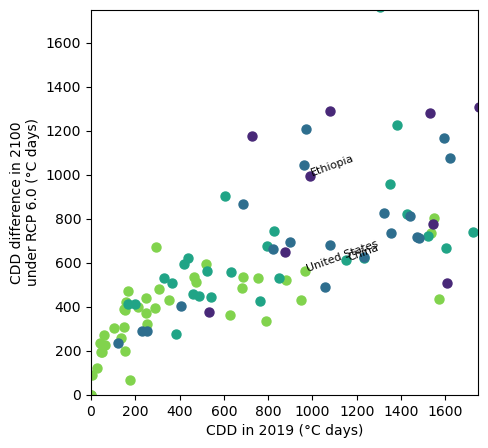

In [ ]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    # Parts of Figure CDD change (Fig.3)
    if scenario == 'historical':
        scen = ''
        vars = ['CDD', 'GDP']
    else:
        scen = '_'+scenario+'_2100_diff'
        vars = ['CDD_{}_2100_diff'.format(scenario)]
    plot_variable_histogram(config, ac_data, 'CDD'+scen)
    
    # Figure GDP and CDD maps (Fig.1)
    for var in vars:
        plot_variable_map(config, ac_data, var)
    
    if scenario == 'historical':
        # Plot maps highlighting income groups (Fig.4)
        plot_income_groups(config, ac_data)

        # Figure Contours (Fig.2)
        xrange = [config['plotting']['cdd_min'], config['plotting']['cooling_deficit_index_max'], 100]
        yrange = [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]
        # Exposure times CDD
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='exposure_contour')
        # AC adoption
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='AC_adoption_contour', multiply_cdd=False)
        continue

    # Part of Figure GDP growth (Fig.4)
    plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure CDD change (Fig.3)
    plot_cdd_scatter(config, ac_data, scenario)